In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

from models import SFCN
from utils.datasets import TorchDataset as TD

In [2]:
@torch.no_grad()
def test(model, test_path, bias_idx, class_idx):
    batch_size = 32
    test_loader = DataLoader(TD(test_path), batch_size=batch_size, shuffle=False)

    model.eval()
    y_true = []
    y_pred = []

    for batch in tqdm(test_loader, desc='Test'):
        x = batch[0].to('cuda')
        y_true += 1 * (batch[bias_idx] == class_idx).cpu().tolist()
        y_pred += torch.sigmoid(model(x)).detach().cpu().tolist()

    return y_true, y_pred

In [3]:
from sklearn.metrics import roc_curve, auc


def plot_auroc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    print('AUC: ', roc_auc)

    # Create the plot
    plt.figure(figsize=(10, 8))
    plt.plot(
        fpr,
        tpr,
        color='darkorange',
        lw=2,
        label=f'ROC curve (AUC = {roc_auc:.2f})'
    )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

    # Customize the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)

    return roc_auc

## Trained model

Test: 100%|██████████| 9/9 [00:18<00:00,  2.07s/it]


AUC:  0.6215213358070502


Test: 100%|██████████| 9/9 [00:16<00:00,  1.82s/it]


AUC:  0.8641975308641976


Test: 100%|██████████| 9/9 [00:16<00:00,  1.88s/it]


AUC:  0.7091535433070866


Test: 100%|██████████| 9/9 [00:15<00:00,  1.74s/it]


AUC:  0.689789029535865


Test: 100%|██████████| 9/9 [00:13<00:00,  1.47s/it]


AUC:  0.4949494949494949


Test: 100%|██████████| 9/9 [00:13<00:00,  1.51s/it]


AUC:  0.9385072975029397


Test: 100%|██████████| 9/9 [00:13<00:00,  1.49s/it]


AUC:  0.40637450199203184


Test: 100%|██████████| 9/9 [00:13<00:00,  1.46s/it]


AUC:  0.8340928270042194


Test: 100%|██████████| 9/9 [00:13<00:00,  1.45s/it]


AUC:  0.6621543778801844


Test: 100%|██████████| 9/9 [00:13<00:00,  1.50s/it]


AUC:  0.8489583333333334


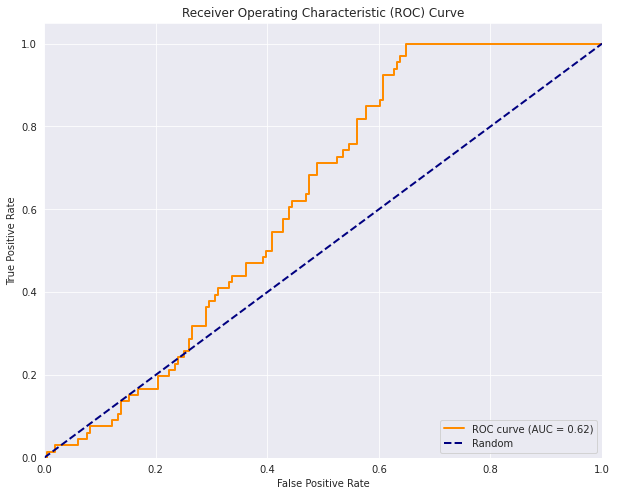

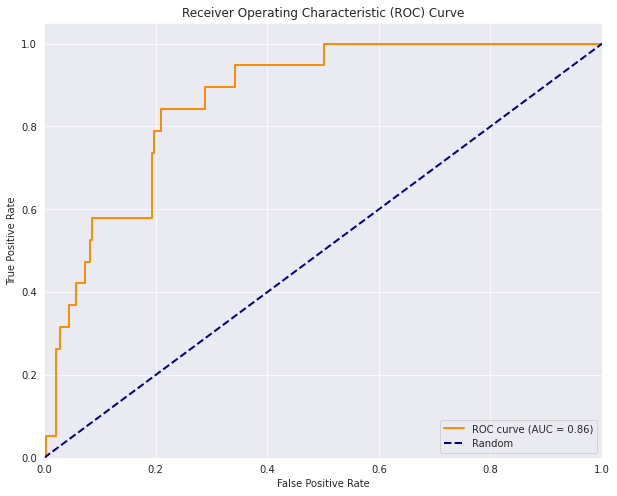

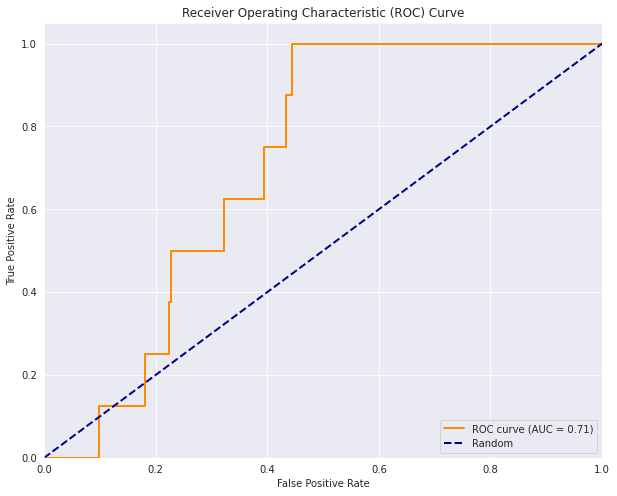

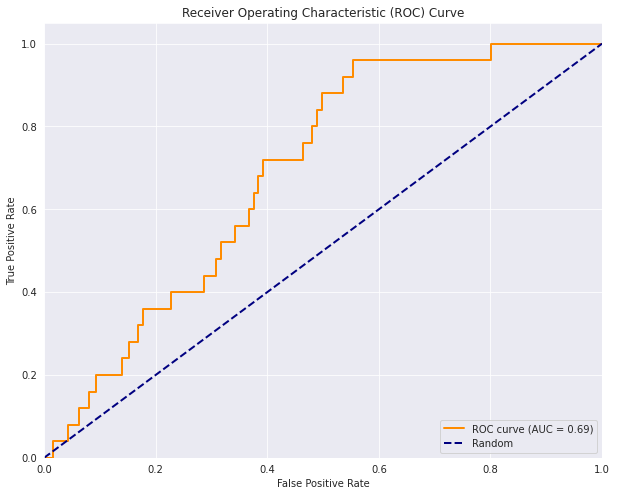

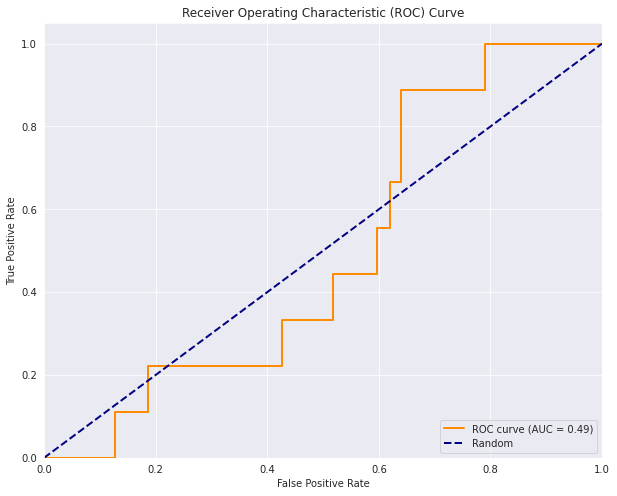

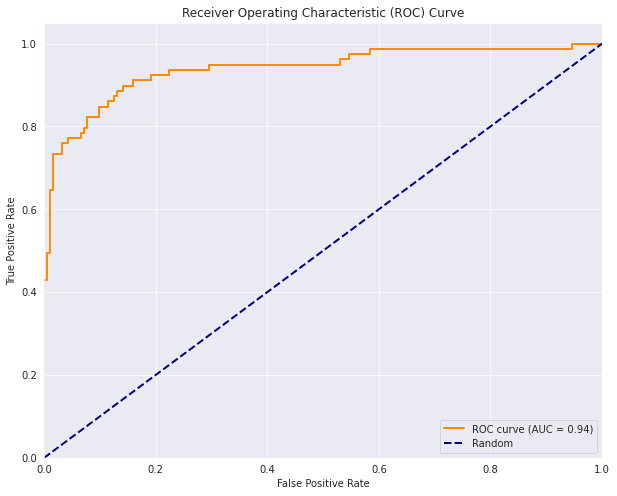

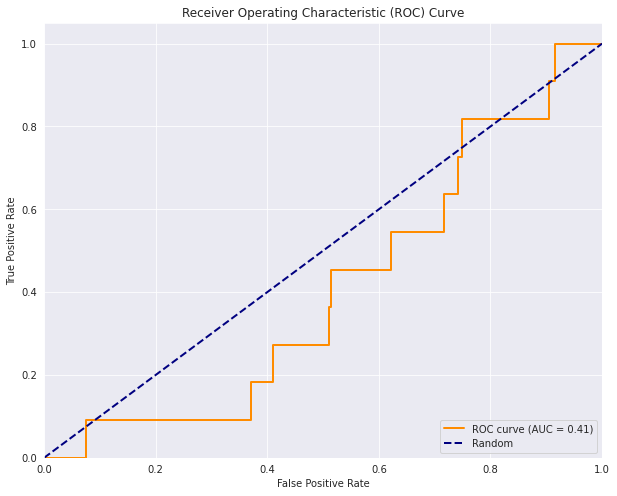

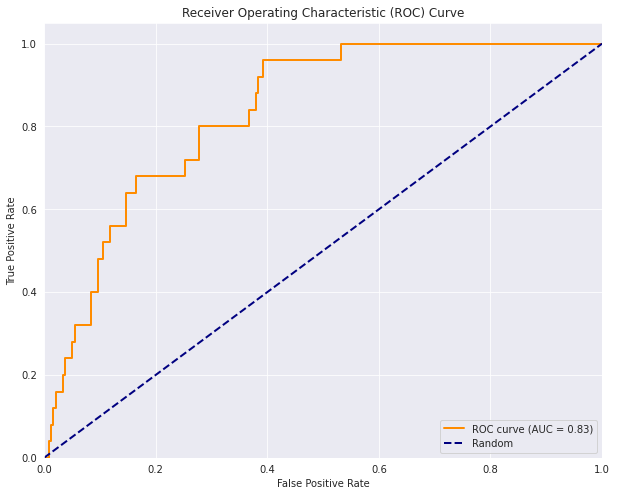

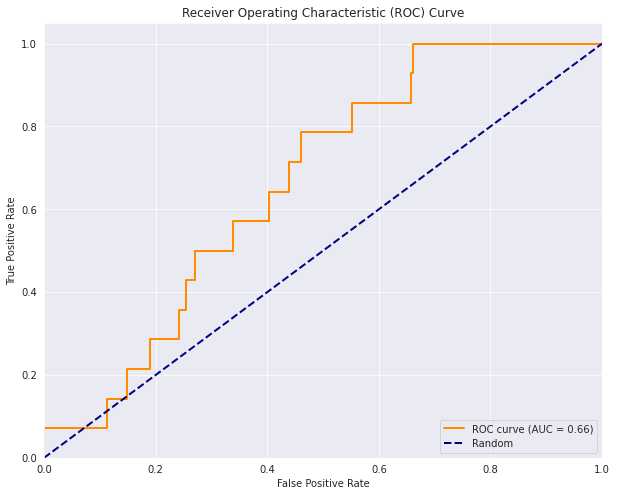

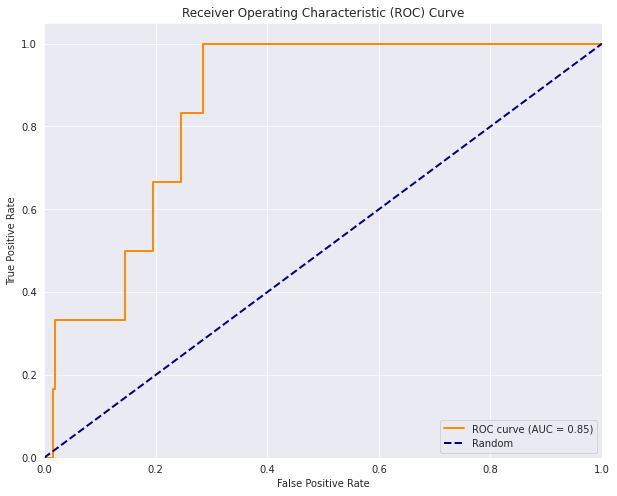

In [4]:
bias_idx = 5
class_idxs = np.arange(10)

aurocs_4 = []

for c in class_idxs:
    model = SFCN().to('cuda')
    checkpoint = torch.load(f'checkpoints/bias-{bias_idx}-{c}/best_model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    y_true, y_pred = test(model, '/data/Data/PD/test', bias_idx, c)
    aurocs_4.append(plot_auroc_curve(y_true, y_pred))

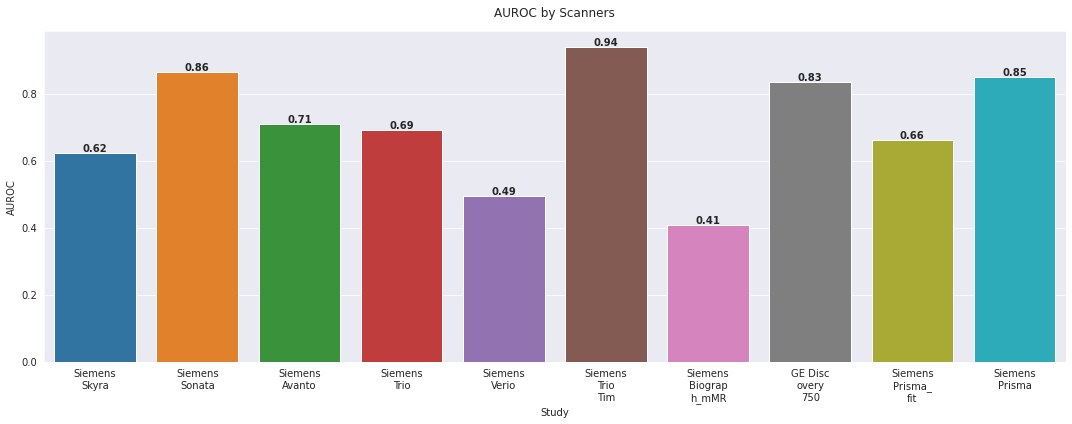

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from bias_registry import BiasRegistry
from textwrap import wrap

bias_registry = BiasRegistry()
# Create figure and axes
fig, ax = plt.subplots(figsize=(15, 6))

# Create barplot
bar_plot = sns.barplot(x=list(bias_registry.scanner_type.keys()), y=aurocs_4)

# Customize the plot
ax.set_title('AUROC by Scanners', pad=15)
ax.set_xlabel('Study')
ax.set_ylabel('AUROC')

# Add value labels on top of each bar
for i, v in enumerate(aurocs_4):
    bar_plot.text(
        i,  # X position
        v,  # Y position
        str(round(v, 2)),  # Text (value)
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontweight='bold'  # Make the text bold
    )

wrapped_labels = ['\n'.join(wrap(label.get_text(), width=7)) for label in ax.get_xticklabels()]
ax.set_xticks(np.arange(len(wrapped_labels)))
ax.set_xticklabels(wrapped_labels)
# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.savefig('/data/Papers/MICCAI-biases/split/scanner_type.pdf')